# This notebook shows you how to clip your raw data files to a bounding box or polygon before actually processing it.

# Reducing your data to an area of interest can greatly speed up downstream processing and reduce the need to operate on unnecessary data.

# This is often your very first step in an analysis.

In [1]:
import trackio as tio
import glob
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt

# First, define the raw files.

In [2]:
#define raw data files
data_path = './files'
files = glob.glob(f'{data_path}/AIS_*.csv')

files

['./files\\AIS_2021_01_01.csv']

# Now, make a column mapper so you can handle any column names that are encountered in the data. Here we'll fill the mapper using the built in mapper.

In [3]:
#make a column mapper for raw data
col_mapper = tio.make_col_mapper(files, 
                                 ncores=1,
                                 fill_mapper=tio.mappers.columns)

col_mapper

Making column mapper: 100%|██████████| 1/1 [00:00<00:00, 665.55it/s]

{'BaseDateTime': 'Time',
 'COG': 'Coursing',
 'CallSign': 'CallSign',
 'Cargo': 'Cargo',
 'Draft': 'Draft',
 'Heading': 'Heading',
 'IMO': 'IMO',
 'LAT': 'Y',
 'LON': 'X',
 'Length': 'Length',
 'MMSI': 'MMSI',
 'SOG': 'Speed',
 'Status': 'Status',
 'TranscieverClass': 'TranscieverClass',
 'VesselName': 'Name',
 'VesselType': 'AISCode',
 'Width': 'Width'}

# Notice that X,Y,Time columns have been detected and properly mapped.

# First, you can clip to a polygon:

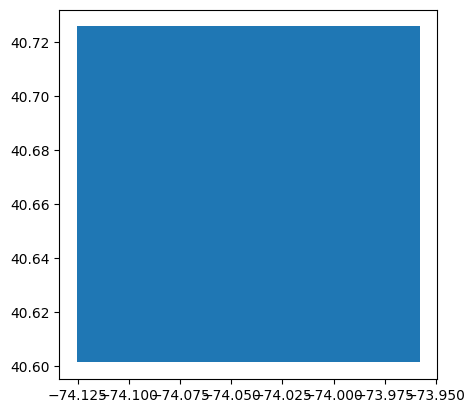

In [4]:
#read the shp/gpkg/geojson
gdf = gp.read_file('files/region.gpkg')
gdf.plot()

#extract the first (and only) geometry
polygon = gdf.geometry[0]

In [5]:
#clip the raw data files to polygon
tio.clip_to_polygon(files, 
                   polygon, 
                   col_mapper=col_mapper,
                   out_pth=data_path, 
                   ncores=1, 
                   pattern='_clipped_to_polygon')

#check for the clipped files
polygon_files = glob.glob(f'{data_path}/*_clipped_to_polygon*')

polygon_files

Clipping raw data: 100%|██████████| 1/1 [00:00<00:00, 666.82it/s]

['./files\\AIS_2021_01_01_clipped_to_polygon.csv']

# You can also do the same with a bounding box:

In [6]:
#define the bounding box - (xmin, ymin, xmax, ymax)
box = polygon.bounds

tio.clip_to_box(files, 
                box,
                col_mapper=col_mapper, 
                out_pth=data_path, 
                ncores=4, 
                pattern='_clipped_to_box')

#check for the clipped files
box_files = glob.glob(f'{data_path}/*_clipped_to_box*')

box_files

Clipping raw data: 100%|██████████| 1/1 [00:00<00:00, 499.56it/s]


['./files\\AIS_2021_01_01_clipped_to_box.csv']

# Below is a quick comparison of the 3 datasets and their size:

82335 72599 72599


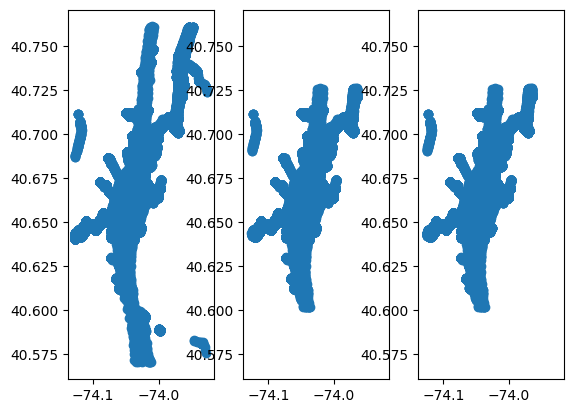

In [7]:
#read the files
df1 = pd.read_csv(files[0])
df2 = pd.read_csv(polygon_files[0])
df3 = pd.read_csv(box_files[0])

#print their length
print(len(df1), len(df2), len(df3))

#plot the points
fig, ax = plt.subplots(1,3)
ax[0].scatter(df1['LON'], df1['LAT'])
ax[1].scatter(df2['X'], df2['Y']) #notice clipped files have column mapping applied
ax[2].scatter(df3['X'], df3['Y']) #notice clipped files have column mapping applied

#make extents equal
for a in ax[1:]:
    a.set_xlim(ax[0].get_xlim())
    a.set_ylim(ax[0].get_ylim())

# The files are now ready to be processed using `trackio`.